### Часть 1. Overfit it (1.5 points)

Simple convolutional neural network for image classification: fashion-MNIST
This notebook shows a model for reaching 92.32% accuracy for fashion-mnist. I tried to create a simple conv net without extremly deep network. Furthermore I evaluate the generalization of the network for classification on tradional MNIST at the end.

Будем работать с датасетом [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) (*hint: он доступен в torchvision*).

Ваша задача состоит в следующем:
1. Обучить сеть, которая покажет >= 0.94 test accuracy.
2. Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).
3. Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

*Примечание*: Пункты 2 и 3 взаимосвязаны, в п.3 Вам прелагается сделать полученную в п.2 сеть менее склонной к переобучению. Пункт 1 является независимым от пунктов 2 и 3.

**Imports and constants**

In [148]:
# Your great code here
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.utils.data import DataLoader, random_split
torch.utils.data.random_split
from torchvision import datasets
from torchvision.transforms import transforms
from torchsummary import summary

from IPython.display import clear_output
from IPython.core.debugger import set_trace
from itertools import chain
import time, sys
from tqdm import tqdm_notebook as tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# if you're running in google colab
# 1. Comment this
%matplotlib inline
# reload modules before executing each line
%reload_ext autoreload
%autoreload 2
# 2. Uncomment this
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
# base_dir = root_dir + 'YDS/'
# data_dir = root_dir + 'data/'
# models_dir = root_dir + 'models/'

print('NumPy version: \t\t%s' % np.__version__)
print('PyTorch version: \t%s' % torch.__version__)

import warnings
warnings.filterwarnings('ignore')

NumPy version: 		1.16.3
PyTorch version: 	1.0.1.post2


In [149]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
BASE_PATH = './'
DATA_PATH = r"../data/" # PATH TO THE DATASET
MODELS_PATH = r"../models/" # PATH TO FOLDER w\ pre-trained models weights

# If true, save model parameters to GDrive
COLAB = False

# Number of threads for data loader
NUM_WORKERS = 4

# 
ratio = 0.2

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 28

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 20

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 64

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 128

# Images mean and std channelwise
image_mean = [0.2861]
image_std  = [0.3529] #[0.3526]


# Number of classes in the dataset
NUM_CLASSES = 10

english_labels = ["T-shirt/top",
                  "Trouser",
                  "Pullover",
                  "Dress",
                  "Coat",
                  "Sandal",
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle boot"]

**Data preprocessing** 

In [150]:
## Use `norm = False` to count image_mean and image_std
norm = True
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=image_mean,
                                                    std=image_std)])

train_data = datasets.FashionMNIST(DATA_PATH, train=True, download=True,
                                   transform=transform if norm else transforms.ToTensor())

test_data = datasets.FashionMNIST(DATA_PATH, train=False, download=True,
                                  transform=transform if norm else transforms.ToTensor())

val_size = int(ratio * len(train_data)) 

train_data, val_data = random_split(train_data, 
                                    [len(train_data) - val_size , val_size])

train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True if norm else False, 
                          num_workers=NUM_WORKERS)

val_loader = DataLoader(val_data, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True if norm else False, 
                        num_workers=NUM_WORKERS)

test_loader = DataLoader(test_data, 
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=NUM_WORKERS)
# val_loader = test_loader

In [151]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(48000, 12000, 10000)

In [53]:
if not norm:
    # Count mean for each channel. Assume t.shape == (batch_size, channels, h, w)
    image_mean = torch.stack([torch.mean(t, (0,2,3)) for t, c in train_loader])
    image_mean = torch.mean(image_mean, 0)

    # Count std for each channel. Assume t.shape == (batch_size, channels, h, w)
    image_std = torch.stack([torch.sqrt(
            torch.mean((t - torch.mean(t, (0,2,3), keepdim=True))**2, (0,2,3))) for t, c in train_loader])
    image_std = torch.mean(image_std, 0)

print(image_mean, image_std)

[0.2861] [0.3529]


torch.Size([1, 28, 28])
9 Ankle boot


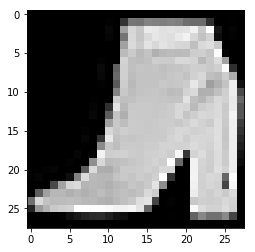

In [54]:
# Let's take a look at our data

img, target = train_data[56]
# channel x width x height
print(img.shape)
print(target, english_labels[target])

fig, ax = plt.subplots(1, 1)
ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))
plt.show()

**Model definition**

In [55]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # _ x 1 x 28 x 28
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            # _ x 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 32 x 14 x 14

            nn.Conv2d(32, 32, 3, padding=1),
            # _ x 32 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            # _ x 32 x 7 x 7    
        )

        self.fc = nn.Sequential(
            # this converts our 2D feature maps to 1D feature vectors
            Flatten(),
            # _ x 32 * 7 * 7 
            nn.Linear(32 * 7 * 7, EMBEDDING_SIZE),
            nn.ReLU()
        )
        
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x
        
    def reset_parameters(self):
        for module in chain(self.model,  self.fc, self.pred):      
            try:
                module.reset_parameters()
                print(module)
            except AttributeError:
                pass

class GoodCNN(nn.Module):
    def __init__(self):
        super(GoodCNN, self).__init__()
        # _ x 1 x 28 x 28
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            # _ x 16 x 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 16 x 14 x 14
            nn.Conv2d(16, 32, 3, padding=1),
            # _ x 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # _ x 32 x 7 x 7             
            nn.Conv2d(32, 64, 3, padding=1),
            # _ x 64 x 7 x 7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
            # _ x 64 x 3 x 3
        )

        self.fc = nn.Sequential(
            # this converts our 2D feature maps to 1D feature vectors
            Flatten(),
            # _ x 64 * 3 * 3 
            nn.Linear(64 * 3 * 3, EMBEDDING_SIZE),
            nn.ReLU()
        )
        
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.pred(x)
        return x
        
    def reset_parameters(self):
        for module in chain(self.model,  self.fc, self.pred):      
            try:
                module.reset_parameters()
                print(module)
            except AttributeError:
                pass
 

In [56]:
model = SimpleCNN()
# summary(model, (1, SIZE_H, SIZE_W))
model = GoodCNN()
# summary(model, (1, SIZE_H, SIZE_W))

**Train and test loops**

In [57]:
def train_model(model, train_batch_generator, val_batch_generator, 
                opt=None, ckpt_name=None, n_epochs=EPOCH_NUM, 
                annealing=False, verbose=True):
    if verbose:
        print("Train on {} samples, validate on {}".format(len(train_batch_generator.dataset), 
                                                           len(val_batch_generator.dataset)))
    
    logs = {'epoch': [], 'train_loss': [], 'val_loss': [],
        'val_accuracy': [],'top_val_accuracy' : 0, 'lr': []}
    
    best_model = None
    iteration = 0
    top_val_accuracy = 0
    
    if opt:
        optimizer=opt
    else:
        optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=0.001, 
                                    weight_decay=0.0001, 
                                    momentum=0.9)
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.NLLLoss(reduction='mean')

    for epoch in range(n_epochs):
        train_loss = []
        val_loss = []
        val_accuracy = []
        start_time = time.time()
        
        
        if epoch == 10 and annealing:
            optimizer.param_groups[0]['lr'] *= .1  
        elif epoch == 20 and annealing:
            optimizer.param_groups[0]['lr'] *= .1
        
        # TRAIN
        model.train(True) # enable dropout / batch_norm training behavior
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training'):
            # move data to target device
            assert len(X_batch) == len(y_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()    
            optimizer.step()

            train_loss.append(loss.cpu().data.numpy())
            
#             if annealing: scheduler.step(epoch)

        # TEST / VALIDATE
        val_accuracy, val_loss = test_model(model, val_batch_generator, criterion=criterion)
           
        clear_output(wait=True)
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        

        train_loss_value = np.mean(train_loss)
        val_accuracy_value = np.mean(val_accuracy) * 100
        
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_value))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy_value))
        
        #Crutch to add parameter to the model
#         model.register_buffer('val_accuracy', torch.Tensor([val_accuracy_value]))
        
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            print('top val accuracy: %.3f' % top_val_accuracy)
            #save checkpoint of the best model to disk
            with open(MODELS_PATH + ckpt_name, 'wb') as f: torch.save(model, f)
        
        logs['epoch'].append(epoch)
        logs['train_loss'].append(train_loss_value)
        logs['val_loss'].append(val_loss)
        logs['val_accuracy'].append(val_accuracy)
        logs['lr'].append(optimizer.param_groups[0]['lr'])

        
        custom_objects = (logs, )
        
    # Load best model found during trainig
    if ckpt_name is not None:
        with open(MODELS_PATH + ckpt_name, 'rb') as f: best_model = torch.load(f)
 
    return best_model, opt, custom_objects


In [58]:
def test_model(model, test_batch_generator, criterion=None, subset='test', verbose=False):
    """
    Compute model performance on test/validation dataset
    :criterion: used to compute loss
    """
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc, test_batch_loss = [], []
    for X_batch, y_batch in test_batch_generator:
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute logits
        logits = model(X_batch)
        # compute loss if needed
        if criterion is not None:
            loss = criterion(logits, y_batch)
            test_batch_loss.append(loss.cpu().data.numpy())
        
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    test_loss = np.mean(test_batch_loss)
            
    if verbose:
        print("Results:")
        print("  {} accuracy:\t\t{:.2f} %".format(subset, test_accuracy * 100))
        if test_accuracy * 100 > 90:
            print("Amazing!")
        elif test_accuracy * 100 > 70:
            print("Good!")
        else:
            print("We need more magic! Follow instructons below")
    return test_accuracy, test_loss

In [126]:
def lr_finder(model, train_batch_generator, opt, lr_start=1e-6, lr_end=1e1, beta=0.99, plot=True):
    """
    Search for optimal learning rate and plot it's landscape
    Used: docs.fast.ai/callbacks.one_cycle.html and
          sgugger.github.io/the-1cycle-policy.html
    """
    loss_history, lr_history= [], []
    i, avg_loss, best_loss = 0, 0., float('inf')
    
    criterion = nn.CrossEntropyLoss()
    
    # Number of iterations for one epoch
    N = len(train_batch_generator)
    # Evenly distribute lr samples on log scale
    q = (lr_end / lr_start) ** (1/N)
    lr = lr_start
    
    optimizer = opt
    optimizer.param_groups[0]['lr'] = lr
    
    for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Searching'):
        i += 1
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # compute loss, calc grads, perform optimizer step and zero the grads
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        #Smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**i)
        
        #Stop if the loss is exploding
        if i > 1 and smoothed_loss > 4 * best_loss:
            return loss_history, lr_history, best_lr 
          
        #Record the best loss
        if smoothed_loss < best_loss or i==1:
            best_loss = smoothed_loss
            best_lr = lr
            
        #Store the values
        loss_history.append(smoothed_loss)
        lr_history.append(np.log10(lr))
        
        #Do optimizer step
        loss.backward()    

        optimizer.step()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #Update the lr for the next step
        lr *= q
        optimizer.param_groups[0]['lr'] = lr
        
    if plot:
        fig, ax = plt.subplots(1,2)
        ax[0].plot(lr_history,loss_history)
        ax[0].set_xlabel('LR')
        ax[0].set_ylabel('Loss')
        
        ax[1].plot([10 ** x for x in lr_history])
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('LR')
        
    return loss_history, lr_history, best_lr

#### Training
**Part 1**

Обучить сеть, которая покажет >= 0.94 test accuracy.

In [134]:
model = SimpleCNN()
model_name = 'simple_cnn'

lr = 1e-3
opt = torch.optim.Adam(model.parameters(), 
                       lr=lr, 
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                       T_max=3,
                                                       last_epoch=-1)

# Try to load previosly trained model first
try:
    with open(MODELS_PATH + model_name, 'rb') as f: model = torch.load(f)
    try:
        acc = model.state_dict()['val_accuracy'][0].item()
    except KeyError:
        print("Loaded succesfully!")
except (FileNotFoundError, ) as e:
    print("Pre-trained model not found. Err msg: '{}' ".format(e.args[-1]))


acc, _ = test_model(model, val_loader)
print("Model validation accuracy = {:.2f}%".format(acc * 100))
summary(model, (1, SIZE_H, SIZE_W))

Pre-trained model not found. Err msg: 'No such file or directory' 
Model validation accuracy = 18.60%
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 256]         401,664
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
       LogSoftmax-11                   [-1, 10]               0
Total params: 413,802
Trainable params: 413,802
Non-trainable par

In [135]:
bm, optim, custom_obj = train_model(model, train_loader, val_loader, opt, 
                                    ckpt_name=model_name, n_epochs=30, 
                                    verbose=False, annealing=True)

Epoch 30 of 30 took 55.021s
  training loss (in-iteration): 	0.215101
  validation accuracy: 			91.06 %


Text(0, 0.5, 'Validation accuracy')

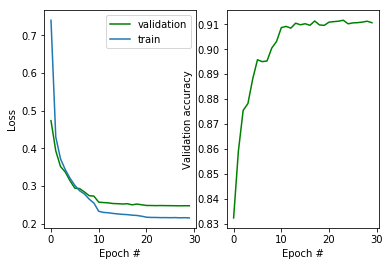

In [139]:
logs = custom_obj[0]
plt.subplot(1, 2, 1)
plt.plot(logs['epoch'], logs['val_loss'],'g-', label='validation')
plt.plot(logs['epoch'], logs['train_loss'], label = 'train')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
# fig, ax = plt.subplots(2, 2)
plt.plot(logs['epoch'], logs['val_accuracy'],'g-')
plt.xlabel('Epoch #')
plt.ylabel('Validation accuracy')
# plt.legend()

In [140]:
# Fimal test
test_model(bm, test_loader, verbose=True)

Results:
  test accuracy:		90.28 %
Amazing!


(0.90283203125, nan)

**Part 2**

Пронаблюдать и продемонстрировать процесс переобучения сети с увеличением числа параметров (==нейронов) и продемонстрировать это наглядно (например, на графиках).

In [ ]:
log = []
for EMBEDDING_SIZE in [256, 512, 1024, 2048]:
    model = SimpleCNN()
    model_name = 'simple_cnn_{}'.format(EMBEDDING_SIZE)

    lr = 3e-4
    opt = torch.optim.Adam(model.parameters(), 
                           lr=lr, 
                           betas=(0.9, 0.99), 
                           eps=1e-08, 
                           weight_decay=0)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                           T_max=3,
                                                           last_epoch=-1)

    _, _, custom_obj = train_model(model, train_loader, val_loader, opt, ckpt_name=model_name, n_epochs=3, verbose=False)
    log.append(custom_obj[0])
    

In [ ]:
size = [256, 512, 1024, 2048]
plt.figure(num=None, figsize=(18, 6), facecolor='w', edgecolor='k')
for i, logs in enumerate(log):
    plt.subplot(1, 3, 1)
    plt.plot(logs['epoch'], logs['val_loss'], label='validation_{}'.format(size[i]))
    plt.plot(logs['epoch'], logs['train_loss'], label = 'train_{}'.format(size[i]))
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    # fig, ax = plt.subplots(2, 2)
    plt.plot(logs['epoch'], logs['val_accuracy'], label='model_{}'.format(size[i]))
    plt.xlabel('Epoch #')
    plt.ylabel('Validation accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    diff = [i - j for i, j in zip(logs['val_loss'], logs['train_loss'])]
    plt.plot(logs['epoch'], diff, label='model_{}'.format(size[i]))
    plt.xlabel('Epoch #')
    plt.ylabel('Val and test loss difference')
    plt.legend()

На третьем графике видно, как ошибка на валидации сначала уменьшается и приближается к ошибке на обучающей выборке, но в какой-то момент начинаеет расти -- это и есть переобучение (сеть запоминает данные вместо выявления закономерностей и начинает сильнее ошибаться на тесте). 

**Part 3**

Попробовать частично справиться с переобучением с помощью подходящих приемов (Dropout/batchnorm/augmentation etc.)

In [157]:
# EMBEDDING_SIZE = 256
model = GoodCNN()
model_name = 'good_cnn'

lr = 3e-4
opt = torch.optim.Adam(model.parameters(), 
                       lr=lr, 
                       betas=(0.9, 0.99), 
                       eps=1e-08, 
                       weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                       T_max=3,
                                                       last_epoch=-1)

# # Try to load previosly trained model first
try:
    with open(MODELS_PATH + model_name, 'rb') as f: model = torch.load(f)
    try:
        acc = model.state_dict()['val_accuracy'][0].item()
    except KeyError:
        acc, _ = test_model(model, val_loader)
    print("Loaded succesfully!")
    print("Model validation accuracy = {:.2f}%".format(acc * 100))
    summary(model, (1, SIZE_H, SIZE_W))
except (FileNotFoundError, ) as e:
    print("Pre-trained model not found. Err msg: '{}' ".format(e.args[-1]))


Loaded succesfully!
Model validation accuracy = 89.92%
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
        MaxPool2d-12             [-1, 64, 3, 3]               0
          Flatten-13                  [-1, 576] 

In [ ]:
bm, optim, custom_obj = train_model(model, train_loader, val_loader, 
                                    ckpt_name=model_name, n_epochs=30, 
                                    verbose=False, annealing=True)

Text(0, 0.5, 'Validation accuracy')

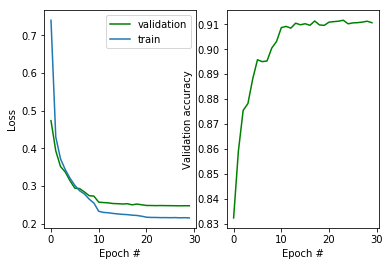

In [155]:
logs = custom_obj[0]
plt.subplot(1, 2, 1)
plt.plot(logs['epoch'], logs['val_loss'],'g-', label='validation')
plt.plot(logs['epoch'], logs['train_loss'], label = 'train')
plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
# fig, ax = plt.subplots(2, 2)
plt.plot(logs['epoch'], logs['val_accuracy'],'g-')
plt.xlabel('Epoch #')
plt.ylabel('Validation accuracy')

In [156]:
# Fimal test
test_model(bm, test_loader, verbose=True)

Results:
  test accuracy:		90.37 %
Amazing!


(0.9036624203821656, nan)

**Fine-tunning**

Используем предобученный ResNet и обучаем лишь полносвязный слой, оставляя нетронутым все остальные.

In [143]:
resnet18 = models.resnet18(pretrained=True)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/zakajd/.torch/models/resnet18-5c106cde.pth
46827520it [00:36, 1278463.07it/s]


In [144]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [145]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co